In [10]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist

In [11]:
# Hyperparameters
cuda = True
epochs = 10
log_interval = 400
batchSize = 16

hidden_layer_sizes = [3 * 32 * 32, 256, 10]

lr = 0.001

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linears = nn.ModuleList([nn.Linear(hidden_layer_sizes[i], hidden_layer_sizes[i+1]) for i in range(len(hidden_layer_sizes) - 1)])        
        # self.init_layers()
        
    def init_layers(self):
        
        for i, l in enumerate(self.linears):
            if i > 0:
#                 norms = torch.norm(self.linears[i].weight.data, 2, 0).repeat(self.linears[i].weight.size(0), 1)
#                 self.linears[i].weight.data = self.linears[i].weight.data.div(norms * 0.587)
                bias = torch.FloatTensor(self.linears[i].weight.data.size(1), 1).fill_( - 1. *np.sqrt(2. / np.pi))
                bias = torch.mm(self.linears[i].weight.data, bias)
                self.linears[i].bias.data.add_(bias)
            

    def forward(self, x):
        activations = 0
        x = x.view(-1, 3 * 32 * 32)
        for i, l in enumerate(self.linears):
            x = F.relu(l(x))
            if i + 2 == len(hidden_layer_sizes):
                break
            if type(activations) is np.ndarray:
                activations = np.append(activations, np.expand_dims(torch.sign(x).cpu().data.numpy(), axis=1), axis=1)
            else:
                activations = np.expand_dims(torch.sign(x).cpu().data.numpy(), axis=1)
        return x, activations
    
model = Net()
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

Net (
  (linears): ModuleList (
    (0): Linear (3072 -> 256)
    (1): Linear (256 -> 10)
  )
)


In [19]:
class ActivationFollower():
    
    train_activations = 0
    train_labels = 0
    test_activations = 0
    test_labels = 0
    
    def __init__(self):
        train_activations = 0
        train_labels = 0
        test_activations = 0
        test_labels = 0
    
    def reset(self):
        train_activations = 0
        train_labels = 0
        test_activations = 0
        test_labels = 0
    
    def train_add(self, x, y):
        if type(self.train_activations) is np.ndarray:
            self.train_activations = np.append(self.train_activations, x, axis=0)
            self.train_labels = np.append(self.train_labels, y, axis=0)
        else:
            self.train_activations = x
            self.train_labels = y
    
    def test_add(self, x, y):
        if type(self.test_activations) is np.ndarray:
            self.test_activations = np.append(self.test_activations, x, axis=0)
            self.test_labels = np.append(self.test_labels, y, axis=0)
        else:
            self.test_activations = x
            self.test_labels = y
        
    def print_metrics(self):
        bins = np.arange(0, 1.1, 0.1)
        proba_activate_layer = []
        for i in range(len(hidden_layer_sizes) - 2):
            proba_activate_layer += [np.where(self.train_activations[:,i] == 0., 1, 0).mean(0)]
            
        data = np.vstack(proba_activate_layer).T
        plt.figure(figsize=(20,10))
        plt.hist(data, bins, label=['Layer : {}'.format(i) for i in range(1, len(proba_activate_layer) + 1)])
        plt.legend()
        plt.title('Histogram of probability of activation')
        plt.show()
        # Here sample and compute histogram of distances.
        # Then Matrix with std of distances between classes.
        

In [20]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [21]:
if cuda:
    model.cuda()
    criterion.cuda()

In [22]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output, activations = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data[0]))

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output, activations = model(data)
        test_loss += criterion(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(testloader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    
def activation_metrics():
    metrics = ActivationFollower()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output, activations = model(data)
        metrics.train_add(activations, target.cpu().data.numpy())
        if batch_idx > 250:
            break
#     for batch_idx, (data, target) in enumerate(testloader):
#         if cuda:
#             data, target = data.cuda(), target.cuda()
#         data, target = Variable(data), Variable(target)
#         output, activations = model(data)
#         metrics.test_add(activations, target.cpu().data.numpy())
        
    metrics.print_metrics()

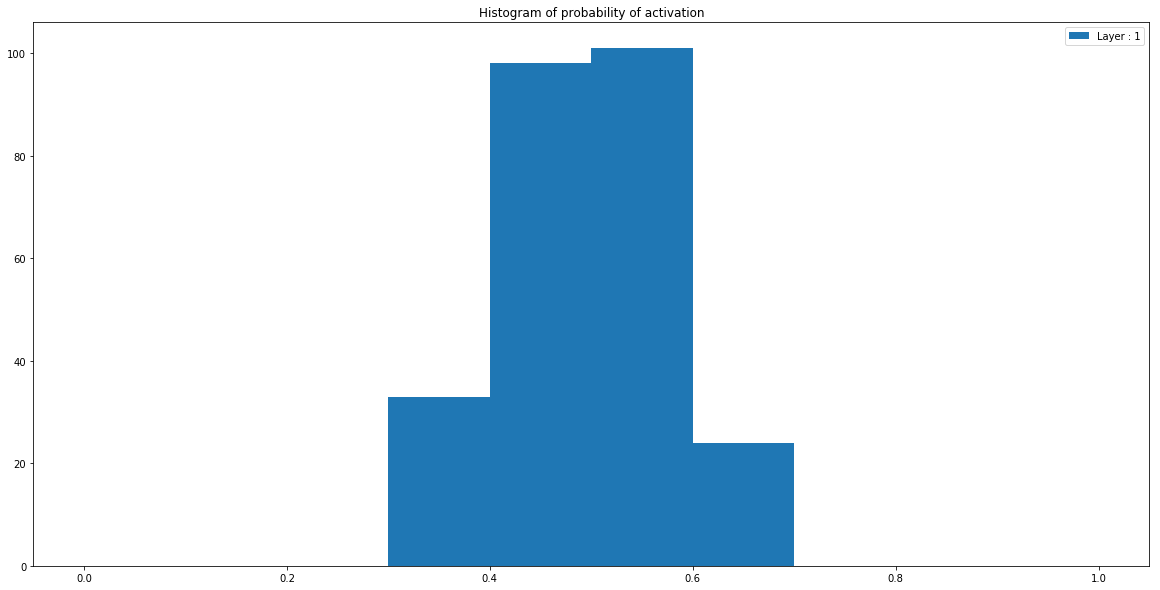

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.295328
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.982233
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.582622
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.784090
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.579791
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.840452
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.343552
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.558560

Test set: Average loss: 1.5522, Accuracy: 4655/10000 (47%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.462275
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.333315
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.473014
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.541628
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.164596
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.176357
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.489883
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.539343

Test set: Average loss: 1.4740, Accuracy: 4863/10000 (49%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.408056
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.442

Process Process-51:
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
Process Process-52:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap


KeyboardInterrupt: 

  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self._target(*self._args, **self._kwargs)
  File "/home/lucas/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 35, in _worker_loop
    r = index_queue.get()
    self.run()
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/queues.py", line 378, in get
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    return recv()
    self._target(*self._args, **self._kwargs)
  File "/home/lucas/anaconda2/lib/python2.7/site-packages/torch/multiprocessing/queue.py", line 21, in recv
  File "/home/lucas/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 41, in _worker_loop
    buf = self.recv_bytes()
    samples = collate_fn([dataset[i] for i in batch_indices])
KeyboardInterrupt
  File "/home/lucas/anaconda2/lib/python2.7/site-packages/torchvision-0.1.8-py2.7.egg/torchvision/datasets/cif

In [23]:
activation_metrics()

for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    
activation_metrics()

In [ ]:
44, 49, 50, 51, 52